Last Update: 20/02/2022

PyCaret Version: 2.0

Author: Haithem Hermessi

Email: haithem.hermessi@fst.utm.tn


# Installing PyCaret 2.0
# Mounting the Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


About Dataset:
This dataset contains around 65k+ traffic-related violation records.

Attribute Information:

**stop_date** - Date of violation

**stop_time** - Time of violation

**driver_gender** - Gender of violators (Male-M, Female-F)

**driver_age** - Age of violators

**driver_race** - Race of violators

**violation** - Category of violation :
Speeding
**Moving Violation **(Reckless Driving, Hit and run, Assaulting another driver, pedestrian, improper turns and lane changes, etc)
Equipment (Window tint violations, Headlight/taillights out, Loud exhaust, Cracked windshield, etc.)
Registration/Plates
Seat Belt
other (Call for Service, Violation of City/Town Ordinance, Suspicious Person, Motorist Assist/Courtesy, etc.)

**search_conducted** - Whether search is conducted in True and False form

**stop_outcome** - Result of violation

**is_arrested** - Whether a person was arrested in True and False form

**stop_duration** - Detained time for violators approx (in minutes)

**drugsrelatedstop** - Whether a person was involved in drugs crime (True, False)

# Installing Latest PyCaret 2.3 Version

In [2]:
!pip install pycaret==2.3

# Importing pycaret

In [3]:
# Pycaret
from pycaret.regression import *
from pycaret.utils import enable_colab
enable_colab()

RuntimeError: ignored

RuntimeError: ignored

RuntimeError: ignored

Colab mode enabled.


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Imports

In [4]:
# importing the required libraries
import pandas as pd
import numpy as np
# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import missingno as ms
# Manipulating the default plot size
plt.rcParams['figure.figsize'] = 10, 12
# Disable warnings 
import warnings
warnings.filterwarnings('ignore')


# Import Data

In [5]:
# Reading a .csv file by creating a dataframe using pandas
# Reading the datasets
df= pd.read_csv('Traffic Violaions.csv',encoding = "utf-8",on_bad_lines='skip')
dt = df.copy()
print(df.shape)

(52966, 15)


In [6]:
df.head()

,stop_date,stop_time,country_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,1/2/2005,1:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,1/18/2005,8:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2,1/23/2005,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
3,2/20/2005,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
4,3/14/2005,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


# Data Preprocessing & EDA

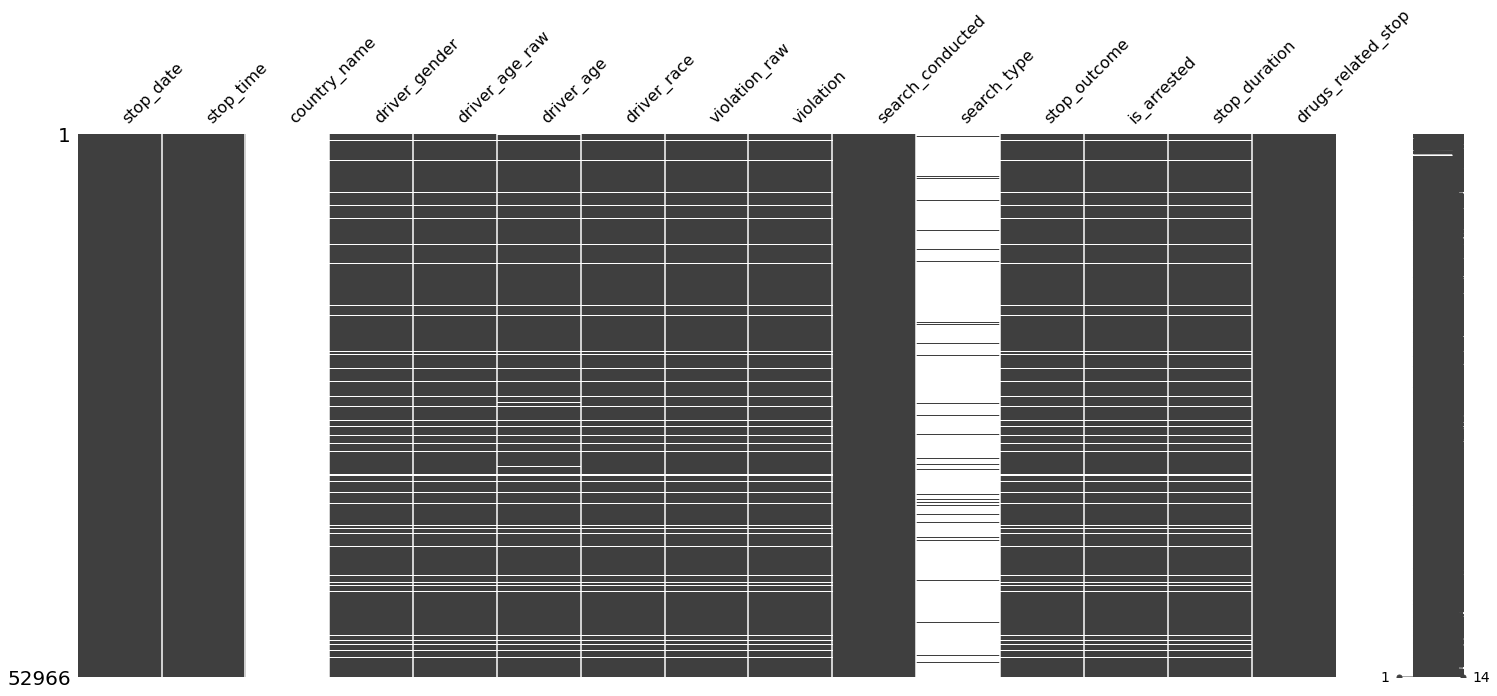

In [7]:
ms.matrix(df)

In [8]:
df1 = df.copy(deep=True)
df1.drop(columns = ['country_name','search_type','driver_age_raw'], inplace=True)
df1.dropna(subset = ['driver_gender'], inplace = True)

In [9]:
df1.isna().sum()

stop_date               0
stop_time               0
driver_gender           0
driver_age            240
driver_race             0
violation_raw           0
violation               0
search_conducted        0
stop_outcome            0
is_arrested             0
stop_duration           0
drugs_related_stop      0
dtype: int64

**1. Some missing values are to remain in the driver_age column. We have to fill these missing values using median.**

**2. After cleaning, we again have to check the remaining missing values.**

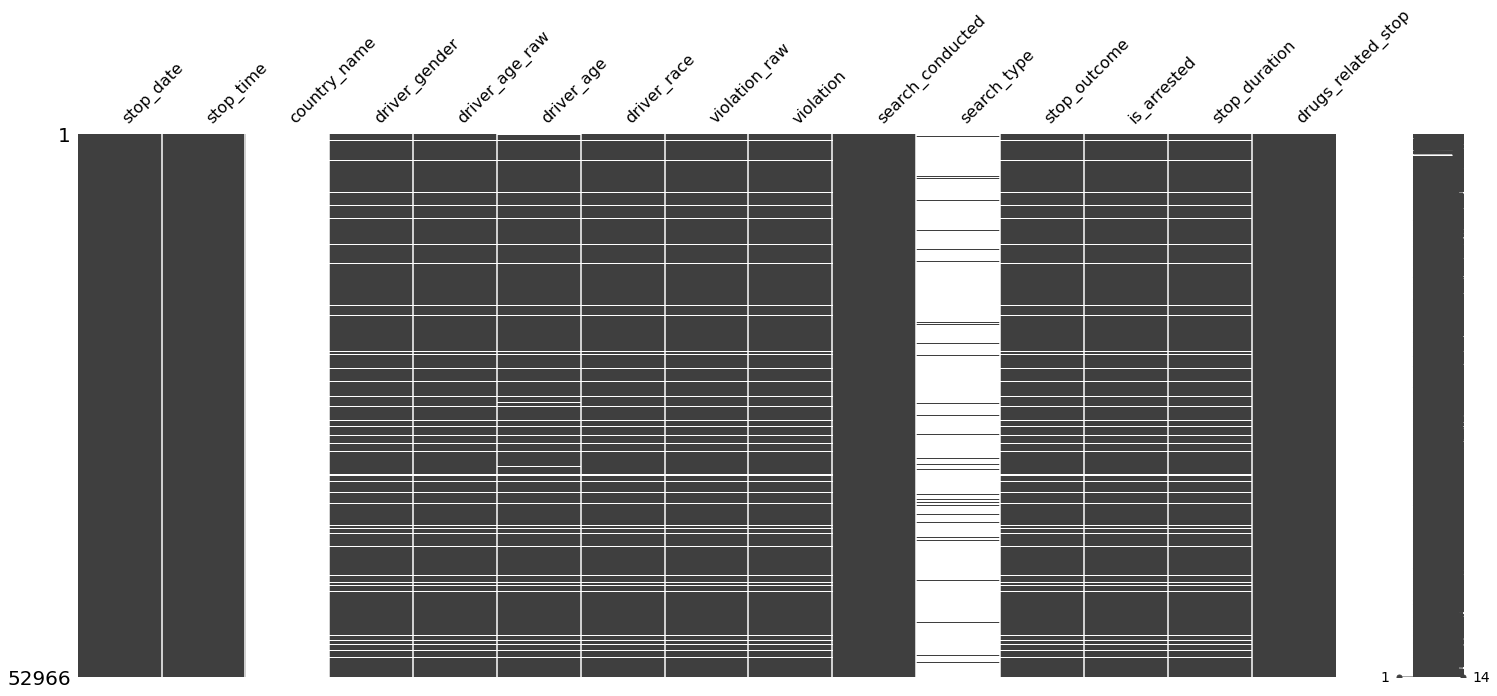

In [10]:
df2 = df1.copy(deep=True)
df2['driver_age'] = df2['driver_age'].fillna(df.groupby('driver_gender')['driver_age'].transform('median'))
ms.matrix(df)
del df ,df1

# Data Manipulation:

In [11]:
data = df2.copy(deep=True)
pd.to_datetime(data['stop_time'])
data['stop_hour'] = pd.to_datetime(data['stop_time'], format = '%H:%M').dt.hour

data['stop_duration'].value_counts()
data['stop_duration'] = data['stop_duration'].map({'0-15 Min':7.5,'16-30 Min':23,'30+ Min':45})
stop_duration_based_on_race = data.groupby('driver_race')[['stop_duration']].mean()

data.search_conducted = data.search_conducted.replace(to_replace=[True, False], value=[1, 0])
data.drugs_related_stop = data.drugs_related_stop.replace(to_replace=[True, False], value=[1, 0])
data['stop_date'] = pd.to_datetime(data['stop_date'])
data['stop_Year'] = pd.DatetimeIndex(data['stop_date']).year
yearly_data = data.groupby('stop_Year').sum()
yearly_data.reset_index(inplace = True)

search_conducted = len(data[data.search_conducted is True])
arrested_after_search = len(data[(data.search_conducted is True) & (data.is_arrested is True)])
arrested = ((arrested_after_search/search_conducted)*100)
not_arrested = (100-(arrested))

**Age Distribution**

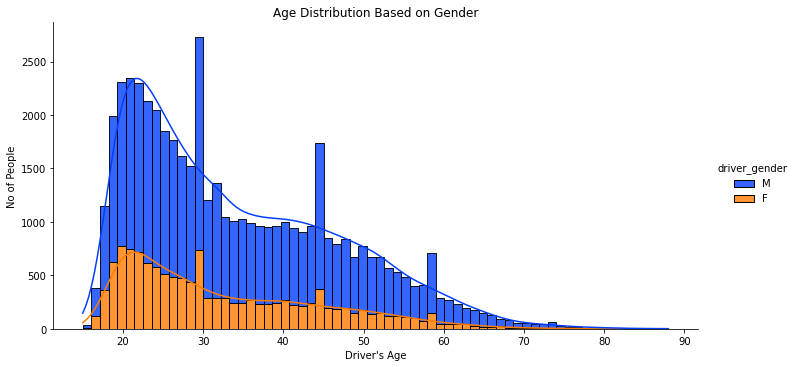

In [12]:
sns.displot(x = 'driver_age', hue = 'driver_gender', kde = True, data = data, 
            multiple = 'stack', alpha = 0.8, palette = "bright", height=5, aspect=2)
plt.title('Age Distribution Based on Gender')
plt.xlabel("Driver's Age")
plt.ylabel("No of People");

**Distribution in Violation Type**

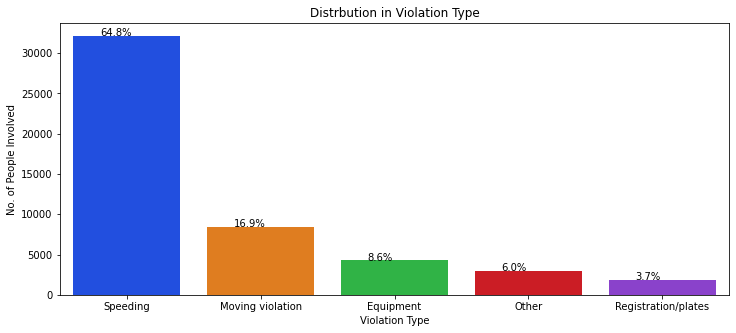

In [13]:
fig , ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x = data.violation, data = data, order = data.violation.value_counts().index, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(data.violation))
    x = i.get_x()+i.get_width()-0.6
    y = i.get_height()
    ax.annotate(percentage, (x, y))
plt.title("Distrbution in Violation Type")
plt.xlabel("Violation Type")
plt.ylabel("No. of People Involved");

**Hours in Which Speed Violated**

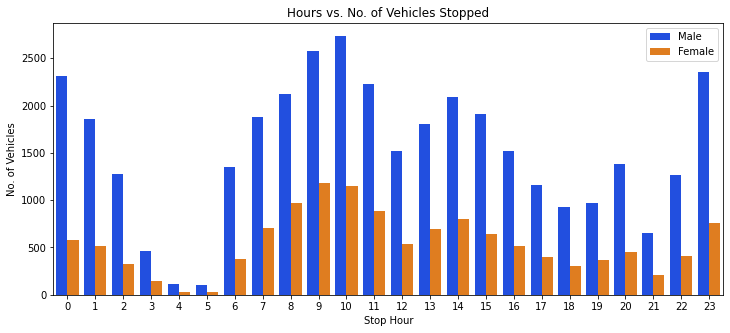

In [14]:
plt.figure(figsize = (12,5))
sns.countplot(x = data.stop_hour,data = data,hue = 'driver_gender', palette = "bright")
plt.title('Hours vs. No. of Vehicles Stopped')
plt.legend(['Male','Female'])
plt.xlabel("Stop Hour")
plt.ylabel("No. of Vehicles");

**Traffic Violation Distribution Based on Race**


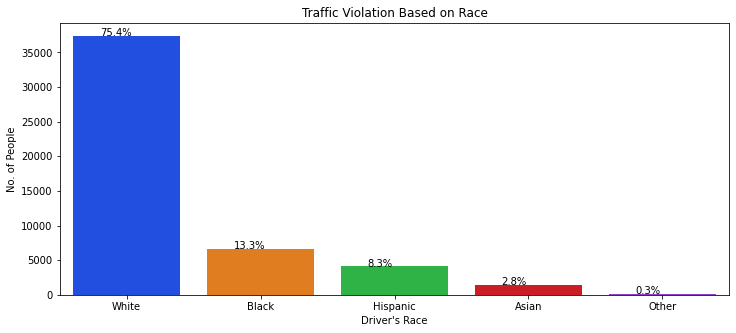

In [15]:
fig , ax = plt.subplots(figsize = (12,5))
ax = sns.countplot(x=data.driver_race, data=data, order = data.driver_race.value_counts().index,
                   linewidth = 0, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(data.driver_race))
    x = i.get_x()+i.get_width()-0.6
    y = i.get_height()
    ax.annotate(percentage, (x, y))
plt.title('Traffic Violation Based on Race')
plt.xlabel("Driver's Race")
plt.ylabel("No. of People");

# Setting up Environment in PyCaret

In [16]:
# Dataset Sampling
RANDOM_SEED = 42
K_FOLDS = 5
def data_sampling(dataset, frac: float, random_seed: int):
    data_sampled_a = dataset.sample(frac=frac, random_state=random_seed)
    data_sampled_b =  dataset.drop(data_sampled_a.index).reset_index(drop=True)
    data_sampled_a.reset_index(drop=True, inplace=True)
    return data_sampled_a, data_sampled_b   

In [17]:
#A random sample of 10% size of the dataset will be get to make predictions with unseen data.
data, data_unseen = data_sampling(df2, 0.9, RANDOM_SEED)
print(f"There are {data_unseen.shape[0]} samples for Unseen Data.")

There are 4958 samples for Unseen Data.


In [18]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44622 entries, 0 to 44621
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stop_date           44622 non-null  object 
 1   stop_time           44622 non-null  object 
 2   driver_gender       44622 non-null  object 
 3   driver_age          44622 non-null  float64
 4   driver_race         44622 non-null  object 
 5   violation_raw       44622 non-null  object 
 6   violation           44622 non-null  object 
 7   search_conducted    44622 non-null  object 
 8   stop_outcome        44622 non-null  object 
 9   is_arrested         44622 non-null  object 
 10  stop_duration       44622 non-null  object 
 11  drugs_related_stop  44622 non-null  object 
dtypes: float64(1), object(11)
memory usage: 4.1+ MB


In [22]:
pipeline = setup(data, target='drugs_related_stop', session_id=42, 
                 log_experiment=False, experiment_name='Drug', 
                 remove_outliers=True,fold_shuffle=True,data_split_shuffle=True)

,Description,Value
0,session_id,42
1,Target,drugs_related_stop
2,Original Data,"(44622, 12)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(29673, 68)"


In [23]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.0085,4.300000e-03,0.0649,1.994000e-01,0.0458,0.7489,2.622
omp,Orthogonal Matching Pursuit,0.0105,4.300000e-03,0.0651,1.902000e-01,0.0458,0.7878,0.065
br,Bayesian Ridge,0.0118,4.300000e-03,0.0651,1.902000e-01,0.0458,0.7886,0.226
lr,Linear Regression,0.0118,4.300000e-03,0.0651,1.900000e-01,0.0459,0.7870,0.718
ridge,Ridge Regression,0.0118,4.300000e-03,0.0651,1.900000e-01,0.0459,0.7873,0.066
ada,AdaBoost Regressor,0.0083,4.400000e-03,0.0657,1.734000e-01,0.0463,0.7691,0.282
rf,Random Forest Regressor,0.0083,4.600000e-03,0.0671,1.400000e-01,0.0477,0.7440,1.344
huber,Huber Regressor,0.0056,5.300000e-03,0.0722,1.500000e-02,0.0498,0.9895,3.446
knn,K Neighbors Regressor,0.0069,5.300000e-03,0.0723,8.200000e-03,0.0508,0.9454,1.863
lightgbm,Light Gradient Boosting Machine,0.0000,0.000000e+00,0.0000,0.000000e+00,0.0000,0.0000,0.073


In [24]:
model_metadata = models()
model_metadata['Name']

ID
lr                          Linear Regression
lasso                        Lasso Regression
ridge                        Ridge Regression
en                                Elastic Net
lar                    Least Angle Regression
llar             Lasso Least Angle Regression
omp               Orthogonal Matching Pursuit
br                             Bayesian Ridge
ard         Automatic Relevance Determination
par              Passive Aggressive Regressor
ransac                Random Sample Consensus
tr                         TheilSen Regressor
huber                         Huber Regressor
kr                               Kernel Ridge
svm                 Support Vector Regression
knn                     K Neighbors Regressor
dt                    Decision Tree Regressor
rf                    Random Forest Regressor
et                      Extra Trees Regressor
ada                        AdaBoost Regressor
gbr               Gradient Boosting Regressor
mlp                            

# When it is not certain try GBoosting

In [26]:
xgboost  = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0081,0.0056,0.0746,0.0220,0.0517,0.7655
1,0.0110,0.0073,0.0854,-0.2821,0.0610,0.8233
2,0.0103,0.0068,0.0826,0.0285,0.0553,0.7927
3,0.0070,0.0038,0.0613,-0.1186,0.0446,0.7824
4,0.0092,0.0059,0.0767,0.0232,0.0527,0.7690
5,0.0095,0.0056,0.0752,-0.4021,0.0537,0.7121
6,0.0080,0.0046,0.0681,0.1347,0.0481,0.6701
7,0.0102,0.0064,0.0801,-0.1252,0.0564,0.7719
8,0.0103,0.0070,0.0836,0.0063,0.0547,0.8039
9,0.0078,0.0041,0.0639,-0.1040,0.0461,0.5619


In [29]:
gbr  = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0077,0.0043,0.0653,0.2523,0.0452,0.7609
1,0.0096,0.0051,0.0712,0.1097,0.0508,0.7878
2,0.0094,0.0051,0.0715,0.2722,0.0492,0.7616
3,0.0066,0.0028,0.0527,0.1733,0.0380,0.7261
4,0.0088,0.0049,0.0699,0.1890,0.0487,0.7902
5,0.0082,0.0036,0.0599,0.1085,0.0436,0.7432
6,0.0078,0.0037,0.0610,0.3053,0.0423,0.7333
7,0.0091,0.0048,0.0695,0.1519,0.0489,0.7787
8,0.0099,0.0053,0.0725,0.2527,0.0507,0.7392
9,0.0075,0.0030,0.0551,0.1793,0.0406,0.6677


In [31]:
ada  = create_model('ada')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0075,0.0043,0.0656,0.2438,0.0455,0.7518
1,0.0093,0.0048,0.0689,0.1655,0.0490,0.7743
2,0.0090,0.0049,0.0700,0.3019,0.0478,0.7574
3,0.0066,0.0030,0.0546,0.1111,0.0393,0.7953
4,0.0086,0.0049,0.0698,0.1915,0.0489,0.7612
5,0.0080,0.0036,0.0600,0.1076,0.0435,0.7643
6,0.0083,0.0041,0.0638,0.2421,0.0449,0.7525
7,0.0086,0.0046,0.0679,0.1902,0.0477,0.7624
8,0.0098,0.0057,0.0756,0.1866,0.0529,0.7792
9,0.0074,0.0037,0.0610,-0.0068,0.0436,0.7924


# SVM

In [32]:
svm = create_model('svm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1032,0.0143,0.1196,-1.5111,0.1041,0.9001
1,0.1025,0.0142,0.1190,-1.4875,0.1035,0.9001
2,0.1043,0.0154,0.1241,-1.1907,0.1064,0.9000
3,0.1011,0.0124,0.1113,-2.6854,0.0999,0.9001
4,0.1032,0.0145,0.1205,-1.4077,0.1044,0.9000
5,0.1011,0.0128,0.1132,-2.1832,0.1007,0.9001
6,0.1026,0.0140,0.1183,-1.6072,0.1033,0.8999
7,0.1029,0.0143,0.1194,-1.5028,0.1039,0.9000
8,0.1039,0.0153,0.1237,-1.1782,0.1060,0.9000
9,0.1015,0.0127,0.1126,-2.4307,0.1006,0.8998


**Fine tune ada **

In [33]:
tuned_ada  = tune_model(ada)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0074,0.0043,0.0658,0.2393,0.0451,0.8013
1,0.0088,0.0045,0.0671,0.2096,0.0470,0.7894
2,0.0091,0.0051,0.0713,0.2765,0.0485,0.7853
3,0.0065,0.0027,0.0520,0.1955,0.0376,0.7485
4,0.0082,0.0046,0.0675,0.2451,0.0463,0.7930
5,0.0079,0.0034,0.0587,0.1460,0.0425,0.7635
6,0.0078,0.0040,0.0629,0.2631,0.0435,0.7690
7,0.0082,0.0045,0.0668,0.2161,0.0463,0.8021
8,0.0095,0.0053,0.0730,0.2420,0.0502,0.7932
9,0.0071,0.0031,0.0555,0.1651,0.0401,0.7677


In [ ]:
tuned_gbr  = tune_model(gbr)

In [ ]:
tuned_xgboost = tune_model(xgboost)

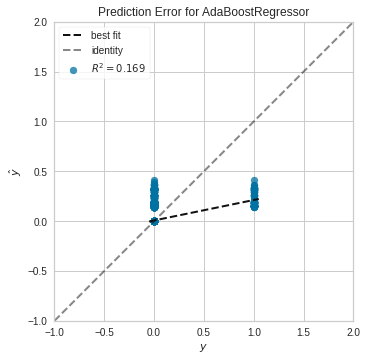

In [34]:
plot_model(tuned_ada, plot = 'error')

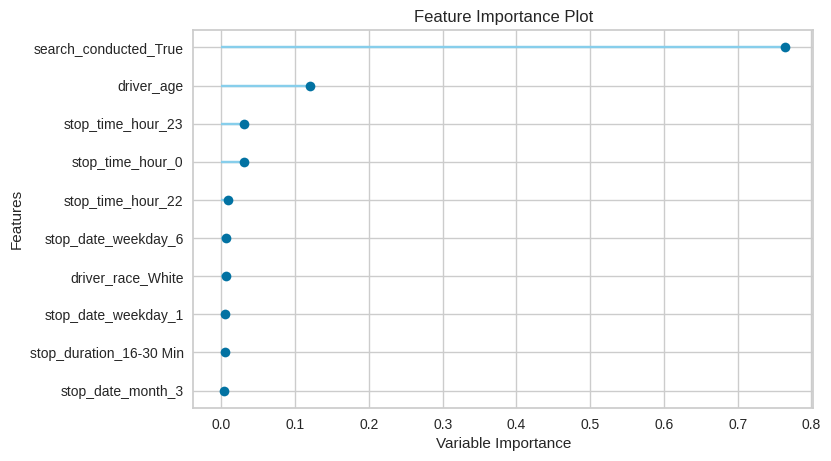

In [35]:
plot_model(tuned_ada, plot='feature')

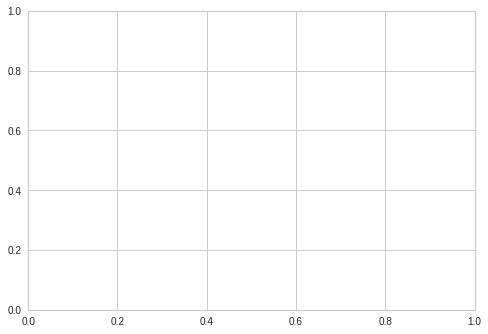

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [37]:
evaluate_model(tuned_ada)

In [ ]:
evaluate_model(tuned_xgboost)

In [ ]:
evaluate_model(tuned_gbr)

In [ ]:
blend = blend_models(estimator_list = [tuned_xgboost, tuned_gbr, tuned_ada])

In [ ]:
pred = predict_model(blend)